
## Data Cleaning
- Decide how to impute null values.
- Decide how to handle outliers.
- Do you want to combine any features?
- Do you want to have interaction terms?
- Do you want to manually drop collinear features?

## Exploratory Visualizations
- Look at distributions.
- Look at correlations.
- Look at relationships to target (scatter plots for continuous, box plots for categorical).

## Pre-processing
- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.
- Consider using automated feature selection.

```
project-2
|__ code
|   |__ 01_EDA_and_Cleaning.ipynb   
|   |__ 02_Preprocessing_and_Feature_Engineering.ipynb   
|   |__ 03_Model_Benchmarks.ipynb
|   |__ 04_Model_Tuning.ipynb  
|   |__ 05_Production_Model_and_Insights.ipynb
|   |__ 06_Kaggle_Submissions.ipynb   
|__ data
|   |__ train.csv
|   |__ test.csv
|   |__ submission_lasso.csv
|   |__ submission_ridge.csv
|__ images
|   |__ coefficients.png
|   |__ neighborhoods.png
|   |__ predictions.png
|__ presentation.pdf
|__ README.md
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [10]:
#Get cleaned datasets:
test = '../datasets/test_cleaned.csv'
train = '../datasets/train_cleaned.csv'

In [11]:
test = pd.read_csv(test)
train = pd.read_csv(train)

In [12]:
#Annotate test and train sets
test['Is_test'] = 1
train['Is_test'] = 0
df = pd.concat([test,train],ignore_index=True,sort=False)
y = df['SalePrice']
df.drop('Unnamed: 0',axis = 1,inplace=True)

In [13]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Is_test,SalePrice
0,190,RM,69.0,9142,0,Grvl,3,Lvl,3,Inside,...,0,0,0,None,0,4,2006,WD,1,NaN
1,90,RL,0.0,9662,0,None,2,Lvl,3,Inside,...,0,0,0,None,0,8,2006,WD,1,NaN
2,60,RL,58.0,17104,0,None,2,Lvl,3,Inside,...,0,0,0,None,0,9,2006,New,1,NaN
3,30,RM,60.0,8520,0,None,3,Lvl,3,Inside,...,0,0,0,None,0,7,2007,WD,1,NaN
4,20,RL,0.0,9500,0,None,2,Lvl,3,Inside,...,0,0,0,None,0,7,2009,WD,1,NaN


In [59]:
# Create target and feature column only correlation list
num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object']
feat_target_corr = df[num_cols].drop("SalePrice", axis=1).apply(lambda x: x.corr(df['SalePrice']))

In [60]:
feat_target_corr.sort_values(ascending = False).head(10)

Overall Qual     0.803813
Gr Liv Area      0.719121
Exter Qual       0.715612
Kitchen Qual     0.694426
Total Bsmt SF    0.665982
Garage Area      0.655624
1st Flr SF       0.648638
Garage Cars      0.648420
Bsmt Qual        0.613126
Year Built       0.573236
dtype: float64

In [ ]:
# Features with high correlation to consider dropping
features_to_drop = ['Overall Qual','Gr Liv Area','Exter Qual']

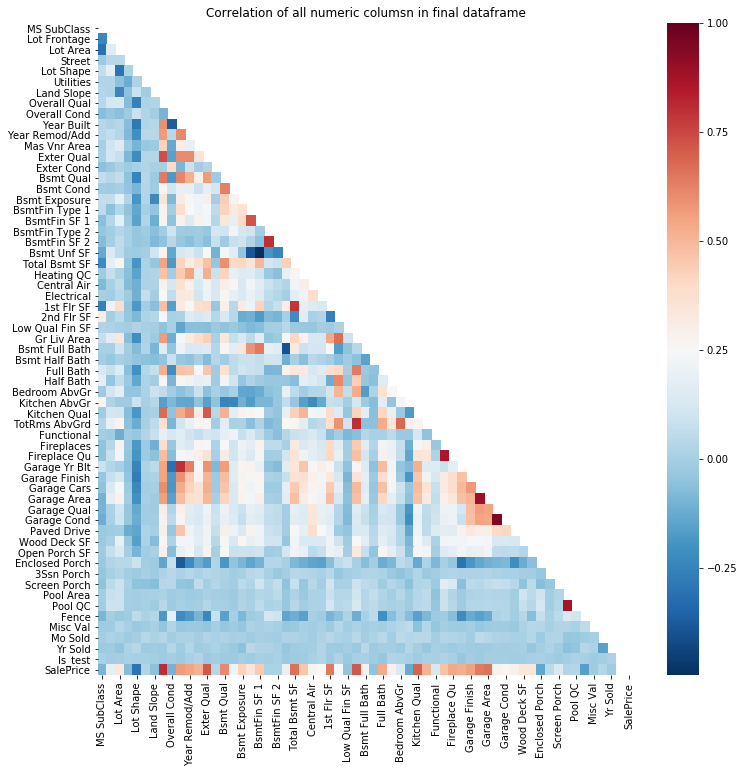

In [16]:
# Looking at heatmap for high correlated items
fig, ax = plt.subplots(figsize=(12,12))
# Compute the correlation matrix

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(),mask = mask, cmap="RdBu_r")
ax.set_title('Correlation of all numeric columsn in final dataframe')

plt.show()

In [31]:
# Look at high correlations
corr = df.corr().abs()
unstack_corr = corr.unstack()
corr_sort = unstack_corr.sort_values(ascending = False)

print(corr_sort[60:110])

MS SubClass     MS SubClass       1.000000
Garage Qual     Garage Cond       0.946088
Garage Cond     Garage Qual       0.946088
Garage Cars     Garage Area       0.892510
Garage Area     Garage Cars       0.892510
Pool QC         Pool Area         0.873444
Pool Area       Pool QC           0.873444
Fireplace Qu    Fireplaces        0.860961
Fireplaces      Fireplace Qu      0.860961
TotRms AbvGrd   Gr Liv Area       0.806678
Gr Liv Area     TotRms AbvGrd     0.806678
Overall Qual    SalePrice         0.803813
SalePrice       Overall Qual      0.803813
Year Built      Garage Yr Blt     0.799342
Garage Yr Blt   Year Built        0.799342
BsmtFin SF 2    BsmtFin Type 2    0.798789
BsmtFin Type 2  BsmtFin SF 2      0.798789
Total Bsmt SF   1st Flr SF        0.787990
1st Flr SF      Total Bsmt SF     0.787990
Exter Qual      Overall Qual      0.733494
Overall Qual    Exter Qual        0.733494
BsmtFin SF 1    BsmtFin Type 1    0.720541
BsmtFin Type 1  BsmtFin SF 1      0.720541
Gr Liv Area

In [21]:
sim_features ['Garage Qual', 'Garage Cars','Pool Area','']

0       1
1       3
2       3
3       3
4       3
5       3
6       3
7       3
8       3
9       3
10      3
11      3
12      3
13      3
14      3
15      3
16      3
17      3
18      3
19      3
20      3
21      3
22      3
23      3
24      3
25      3
26      3
27      1
28      3
29      0
       ..
2888    3
2889    3
2890    3
2891    3
2892    3
2893    3
2894    0
2895    3
2896    3
2897    3
2898    3
2899    3
2900    3
2901    3
2902    2
2903    3
2904    3
2905    3
2906    0
2907    3
2908    3
2909    0
2910    3
2911    3
2912    3
2913    3
2914    3
2915    2
2916    3
2917    3
Name: Garage Cond, Length: 2918, dtype: int64

In [14]:
# Create dummies for columns with categories
dum_cols = [col for col in df.columns if df[col].dtype == 'object']

In [15]:
dum_cols

['MS Zoning',
 'Alley',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Garage Type',
 'Misc Feature',
 'Sale Type']

In [ ]:
df_with_dummies = pd.get_dummies(df, columns=dum_cols, drop_first=True)

## Data Cleaning
- Decide how to impute null values.
- Decide how to handle outliers.
- Do you want to combine any features?
- Do you want to have interaction terms?
- Do you want to manually drop collinear features?


## Exploratory Visualizations
- Look at distributions.
- Look at correlations.
- Look at relationships to target (scatter plots for continuous, box plots for categorical).


## Pre-processing
- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.
- Consider using automated feature selection.

## Modeling
- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.


## Inferential Visualizations
- Look at feature loadings.
- Look at how accurate your predictions are.
- Is there a pattern to your errors? Consider reworking your model to address this.

## Business Recommendations
- Which features appear to add the most value to a home?
- Which features hurt the value of a home the most?
- What are things that homeowners could improve in their homes to increase the value?
- What neighborhoods seem like they might be a good investment?
- Do you feel that this model will generalize to other cities? How could you revise your model to make it more universal OR what date would you need from another city to make a comparable model?